In [5]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import shap
import xgboost as xgb
from sklearn.metrics import auc, roc_curve

from hp_pred.experiments import bootstrap_test

optuna.logging.set_verbosity(optuna.logging.WARNING)

In [6]:
SIGNAL_FEATURE = ['mbp', 'sbp', 'dbp', 'hr', 'rr', 'spo2', 'etco2', 'mac', 'pp_ct']
STATIC_FEATURE = ["age", "bmi", "asa"]
HALF_TIME_FILTERING = [30, 3*60, 60*10]

FEATURE_NAME = (
    [
        f"{signal}_constant_{half_time}"
        for signal in SIGNAL_FEATURE
        for half_time in HALF_TIME_FILTERING
    ]
    + [
        f"{signal}_slope_{half_time}"
        for signal in SIGNAL_FEATURE
        for half_time in HALF_TIME_FILTERING
    ]
    + [
        f"{signal}_std_{half_time}"
        for signal in SIGNAL_FEATURE
        for half_time in HALF_TIME_FILTERING
    ]
    + STATIC_FEATURE
)


BASELINE_FEATURE_NAME = 'last_map_value'

## Load and format data

In [7]:
# import the data frame and add the meta data to the segments
data = pd.read_parquet(Path('data/datasets/base_dataset/cases/'))

static = pd.read_parquet('data/datasets/base_dataset/meta.parquet')

data = data.merge(static, on='caseid')

## Train or load existing model


In [8]:
# control reproducibility
rng_seed = 42

result_folder = Path("data/results")
if not result_folder.exists():
    result_folder.mkdir()
# Set model file, create models folder if does not exist.
model_folder = Path("data/models")
if not model_folder.exists():
    model_folder.mkdir()
model_file = model_folder / "xgb.json"

# create a regressor
if model_file.exists():
    model = xgb.XGBClassifier()
    model.load_model(model_file)
else:
    ImportError("Model file does not exist, run the xgboost study first")

leading_time_list = [3,4,5,6]
for leading_time in leading_time_list:
    data_lead = data[(data.time_before_IOH >= leading_time*60) | (data.time_before_IOH.isna())]

    test = data_lead[data_lead['split'] == "test"].copy()

    test.label_id = test.label_id.astype(str) + test.caseid.astype(str)

    test = test.dropna(subset=FEATURE_NAME)
    print('leading time:', leading_time)
    print(
        f'{len(test)} test samples, positive rate = {test["label"].mean():.2%}'
    )


    # test the model
    y_pred = model.predict_proba(test[FEATURE_NAME])[:, 1]
    y_test = test["label"].values
    y_label_id = test["label_id"].values

    df_results, _, _ = bootstrap_test(y_test, y_pred, y_label_id, n_bootstraps=200, rng_seed=rng_seed)

    roc_results = result_folder / f"xgboost_lead_{leading_time}.csv"
    df_results.to_csv(roc_results, index=False)

    # test baseline
    y_pred_baseline = 1 - test[BASELINE_FEATURE_NAME].values/120

    df_results_baseline, _, _ = bootstrap_test(y_test, y_pred_baseline, y_label_id, n_bootstraps=200, rng_seed=rng_seed)

    roc_results = result_folder / f"baseline_lead_{leading_time}.csv"
    df_results_baseline.to_csv(roc_results, index=False)




leading time: 3
176031 test samples, positive rate = 5.62%


100%|██████████| 200/200 [04:05<00:00,  1.23s/it]


leading time: 4
174432 test samples, positive rate = 4.75%


100%|██████████| 200/200 [04:02<00:00,  1.21s/it]


leading time: 5
172918 test samples, positive rate = 3.92%


100%|██████████| 200/200 [03:24<00:00,  1.02s/it]


leading time: 6
171467 test samples, positive rate = 3.11%


100%|██████████| 200/200 [02:20<00:00,  1.43it/s]


## Plot

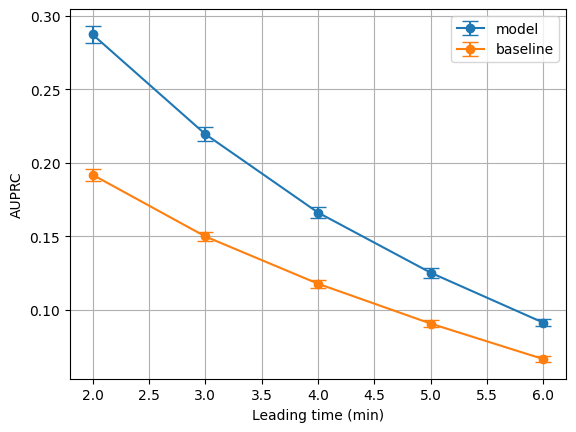

In [12]:
xgboost_auc_list, baseline_auc_list, lead_time_list = [], [], []
xgboost_auc_std_list, baseline_auc_std_list = [], []
leading_time_list = [2,3,4,5,6]
for leading_time in leading_time_list:
    lead_time_list.append(leading_time)
    if leading_time == 2:
        roc_results = result_folder / "xgboost_results.csv"
    else:
        roc_results = result_folder / f"xgboost_lead_{leading_time}.csv"
    df_results = pd.read_csv(roc_results)
    xgboost_auc_list.append(df_results.auprc[0])
    xgboost_auc_std_list.append(df_results.auprc_std[0])

    if leading_time == 2:
        roc_results = result_folder / "baseline_results.csv"
    else:
        roc_results = result_folder / f"baseline_lead_{leading_time}.csv"
    df_results = pd.read_csv(roc_results)
    baseline_auc_list.append(df_results.auprc[0])
    baseline_auc_std_list.append(df_results.auprc_std[0])
    

plt.errorbar(lead_time_list, xgboost_auc_list,xgboost_auc_std_list, fmt='-o', label='model', capsize=6)
plt.errorbar(lead_time_list, baseline_auc_list, baseline_auc_std_list, fmt='-o', label='baseline', capsize=6)
plt.xlabel('Leading time (min)')
plt.ylabel('AUPRC')
plt.grid()
plt.legend()
plt.show()

#save the data
auc_df = pd.DataFrame({'lead_time': lead_time_list, 'xgboost_auc': xgboost_auc_list, 'xgboost_auc_std': xgboost_auc_std_list, 'baseline_auc': baseline_auc_list, 'baseline_auc_std': baseline_auc_std_list})
auc_df.to_csv(result_folder / 'auc_lead_time.csv', index=False)

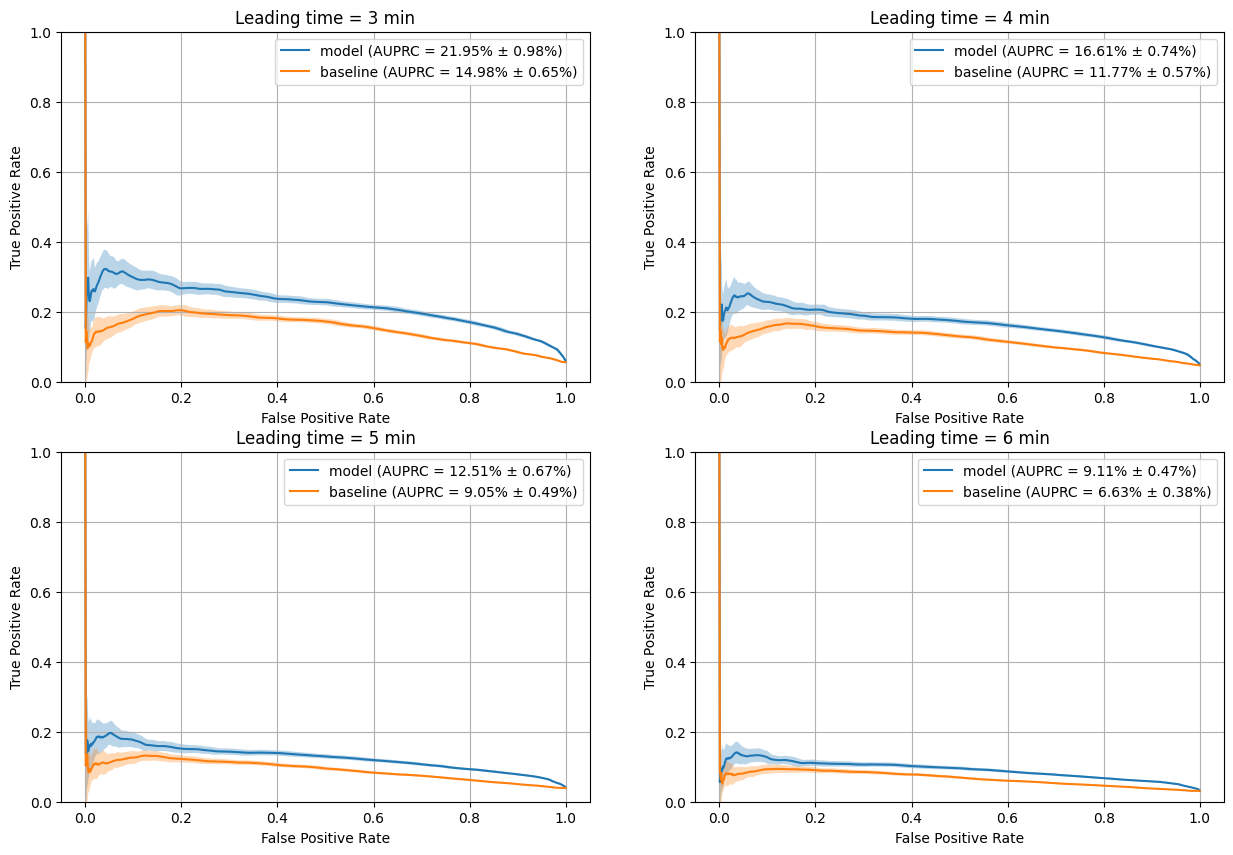

In [10]:
# plot each PRC curve for each leading time in different subplots

fig, axs = plt.subplots(2, 2, figsize=(15, 10))
for leading_time, ax in zip(leading_time_list, axs.flat):
    roc_results = result_folder / f"xgboost_lead_{leading_time}.csv"
    df_results = pd.read_csv(roc_results)
    recall = np.linspace(0, 1, 1000)
    ax.fill_between(recall, df_results.precision - 2*df_results.precision_std, df_results.precision + 2*df_results.precision_std, alpha=0.3)
    ax.plot(recall, df_results.precision, label=f'model (AUPRC = {df_results.auprc[0]:.2%} ± {2*df_results.auprc_std[0]:.2%})')
    baseline_results = result_folder / f"baseline_lead_{leading_time}.csv"
    df_results = pd.read_csv(baseline_results)
    ax.fill_between(recall, df_results.precision - 2*df_results.precision_std, df_results.precision + 2*df_results.precision_std, alpha=0.3)
    ax.plot(recall, df_results.precision, label=f'baseline (AUPRC = {df_results.auprc[0]:.2%} ± {2*df_results.auprc_std[0]:.2%})')
    ax.set_title(f'Leading time = {leading_time} min')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_ylim(0, 1)
    ax.grid()
    ax.legend()